In [27]:
import gseapy; import pandas as pd; import shutil
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm # recommended import according to the docs
from beeswarm import *
import seaborn.apionly as sns
from ggplot import *
from scipy.stats import ttest_ind, ttest_ind_from_stats
import statsmodels.api as sm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style("ticks")
font = {'family' : 'helvetica',
        'size'   : 14}

matplotlib.rc('font', **font)

In [2]:
def S2N(CCLE,sensitive,resistant): # not getting correct values -- too high
    data_s = CCLE[CCLE["Cell.Line"].isin(sensitive)]
    data_r = CCLE[CCLE["Cell.Line"].isin(resistant)]
    sens_genes_mean = []; sens_genes_sd = []
    resi_genes_mean = []; resi_genes_sd = []
    genes_p = []
    for i in range(1 , data_s.shape[1]):
        sens_genes_mean.append(np.mean(data_s[data_s.columns[i]]))
        sens_genes_sd.append(np.std(data_s[data_s.columns[i]], axis = 0, ddof = 1))
        resi_genes_mean.append(np.mean(data_r[data_r.columns[i]]))
        resi_genes_sd.append(np.std(data_r[data_r.columns[i]], axis = 0, ddof = 1))
        genes_p.append(sm.stats.ttest_ind(data_s[data_s.columns[i]],data_r[data_r.columns[i]],alternative="two-sided")[1])
    sens_genes_mean = np.array(sens_genes_mean);sens_genes_sd = np.array(sens_genes_sd)
    resi_genes_mean = np.array(resi_genes_mean);resi_genes_sd = np.array(resi_genes_sd)
    S2N = (sens_genes_mean - resi_genes_mean) / (sens_genes_sd + resi_genes_sd)
    S2N_df = pd.DataFrame({"S2N":S2N, "pvalue":genes_p,
                           "genes":CCLE.columns.tolist()[1:],
                           "sens_mean":sens_genes_mean,
                           "sens_sd":sens_genes_sd,
                           "resi_mean":resi_genes_mean,
                           "resi_sd":resi_genes_sd})
    return S2N_df

In [3]:
def dropUnnamedColumns(DataFrame):
    cols = DataFrame.columns
    indexes = []
    cnt=0
    for i in cols:
        if "Unnamed" in i:
            indexes.append(cnt)
        cnt+=1
    return DataFrame.drop(cols[indexes],axis=1)

In [33]:
test = pd.read_csv("/Users/brentkuenzi/Documents/Drug SVM/R_analysis/CCLE.txt",sep="\t")
test = dropUnnamedColumns(test)
test = test.drop_duplicates(subset=["Cell.Line"])
test_S2N = S2N(test,["NCIH1155_LUNG","NCIH460_LUNG","NCIH1299_LUNG"],["NCIH650_LUNG","NCIH23_LUNG","NCIH661_LUNG","HCC2935_LUNG"])

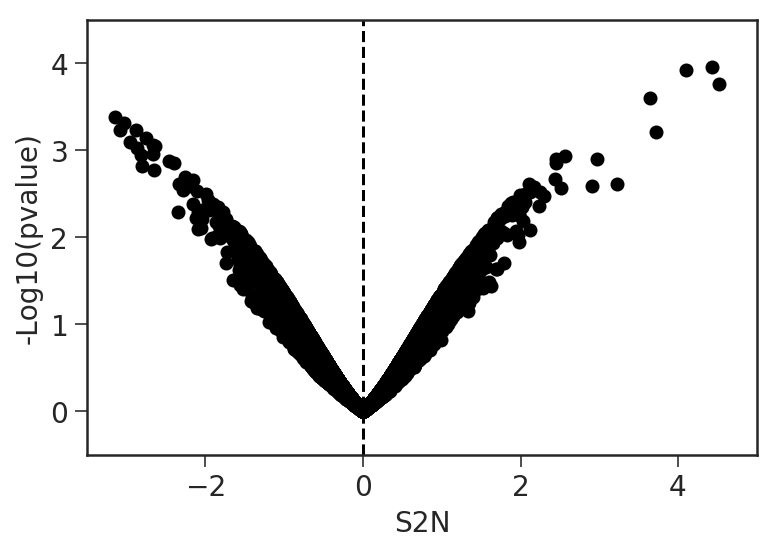

In [34]:
test_S2N["-log10(pvalue)"] = -np.log10(test_S2N["pvalue"])
plt.scatter(data=test_S2N,x="S2N",y="-log10(pvalue)",color="black")
plt.xlim(-3.5,5); plt.ylim(-0.5,4.5)
plt.ylabel("-Log10(pvalue)"); plt.xlabel("S2N")
plt.axvline(0,color="black",ls="dashed")

In [115]:
def scatterhist(x,y,data=None, binwidth=0.25, xlim=None, ylim=None,pointEdgecolors='black',
                pointColor="blue",topHistColor = "gray",rightHistColor = "gray",histEdgeColor="black",
               xlab = "X",ylab="Y",corrLine=True,corrLineColor="black",corrLineWidth=2, histbox = False):
    """
    This function takes either two lists or a pandas dataframe and the column
    names of the comparison to be done and plots the ScatterHist. A trend line 
    is added by default using least squares regression.
    """
    from matplotlib.ticker import NullFormatter
    
    if data != None:
        x = data[x]
        y = data[y]

    rect_scatter = [0.1, 0.1, 0.65, 0.65]
    rect_histx = [0.1, 0.77, 0.65, 0.2]
    rect_histy = [0.77, 0.1, 0.2, 0.65]

    plt.figure(1, figsize=(8, 8))
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    axHistx.xaxis.set_major_formatter(NullFormatter())
    axHisty.yaxis.set_major_formatter(NullFormatter())

    axScatter.scatter(x, y,color=pointColor,edgecolors=pointEdgecolors)
    if corrLine:
        from scipy.stats import linregress
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        print "R = "+str(r_value), ", pvalue = "+str(p_value), ", std err = "+str(std_err)
        axScatter.plot(x, intercept + slope*x,color=corrLineColor,linewidth=corrLineWidth)
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    if xlim!= None:
        xlim = (-lim,lim)
    if ylim!= None:
        ylim = (-lim,lim)
    axScatter.set_xlim(xlim)
    axScatter.set_ylim(ylim)
    axScatter.set_xlabel(xlab,size=18)
    axScatter.set_ylabel(ylab,size=18)
    
    bins = np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(x, bins=bins,color=topHistColor,edgecolor=histEdgeColor)
    axHisty.hist(y, bins=bins, orientation='horizontal',color=rightHistColor,edgecolor=histEdgeColor)
    if histbox == False:
        axHistx.axis("off"); axHisty.axis("off")

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    plt.show()

R = -0.0141210657624 , pvalue = 0.655589271331 , std err = 0.0316321005775


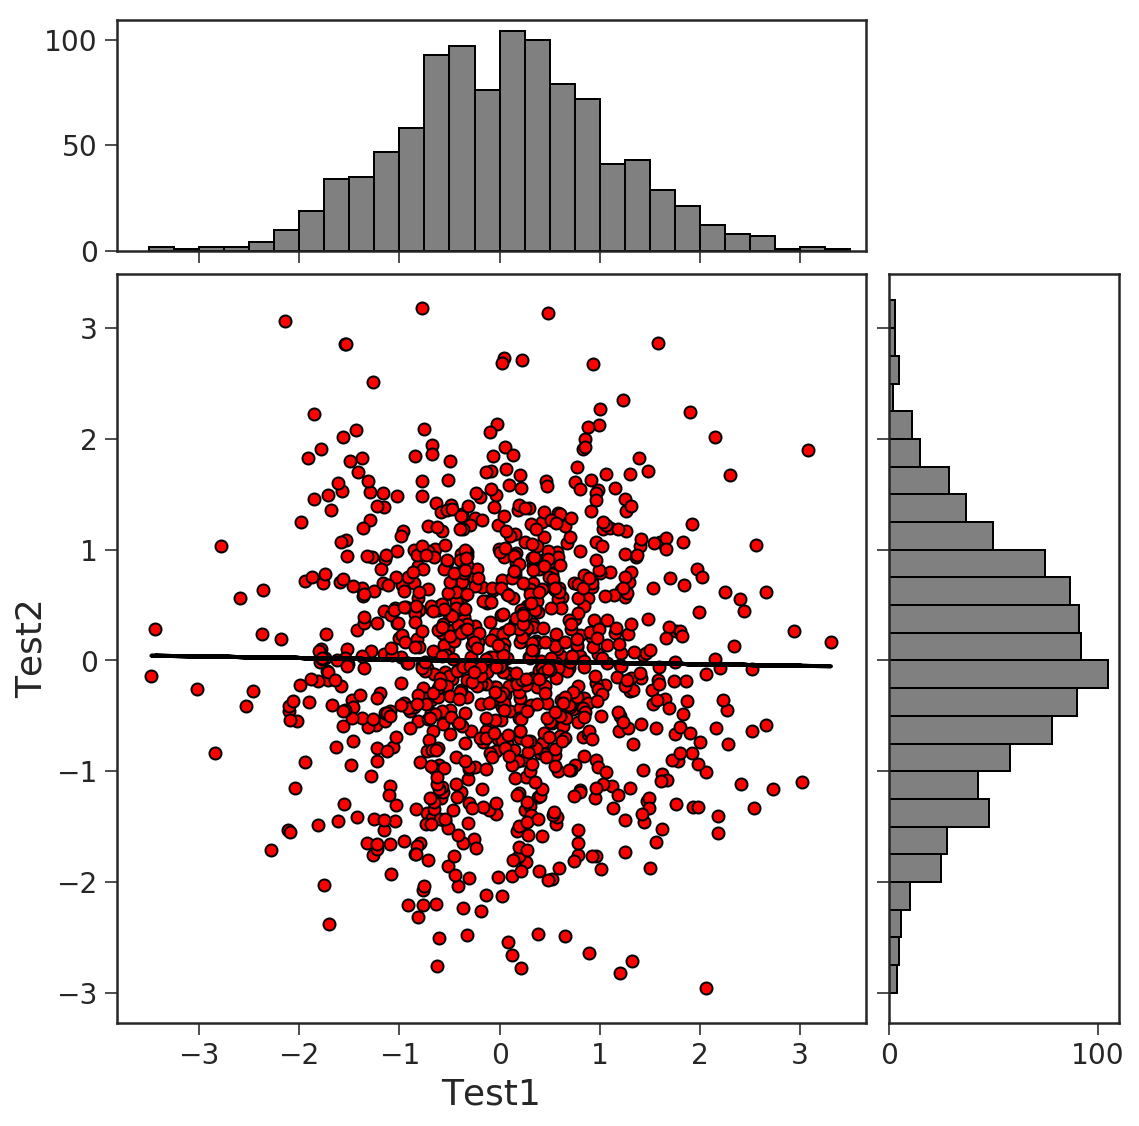

In [116]:
x = np.random.randn(1000)
y = np.random.randn(1000)
scatterhist(x=x,y=y,pointColor="red",xlab="Test1",ylab="Test2",histbox=True)

In [6]:
def KStestRanked(gene_subset,full_set,sort_column,identifier,permutations=5000,direction="up"):
    """
    This function performs a modified Kolmogorov Smirnov test (ranked). gene_subset is
    a list of genes to be tested. full_set is a Pandas dataframe. column is the
    column of the dataset to rank on. Permutations is number of permutations of
    random sampling for p-value estimation. direction is for determination of
    degree of up or downregulation.

    This modification is distinct from a standard KS test in several ways: First, when
    comparing a large distribution to a small distribution in a standard KS test, the NULL
    hypothesis is biased towards being rejected, and thus introduce false positives. Second,
    a ranked KS test allows for the preferential ranking of sets that are separated from the
    background at the tails of the distribution.
    """
    # sort gene_subset and full_set!!!! Sort on "sort_column", identifier is gene names or similar
    t = len(gene_subset); n = len(full_set); u_list = []; cnt = 1
    j = lambda x: full_set[gene_subset in full_set[identifier]].index(x)
    v_j = lambda x: full_set[identifier].index(x)
    if direction == "up":
        for i in gene_subset:
            u_list.append((j(i)/t)-(v_j(i)/n))
        u = max(u_list)
    elif direction == "down":
        for i in gene_subset:
            u_list.append((v_j(i)/n)-((j(i)-1)/t))
        u = max(u_list)
    else:
        sys.exit("Please select 'up' or 'down'")
    perm = 0
    u_instances = 0
    while perm < permutations:
        random = full_set.sample(frac=(t/n)) # do I need to sort this?
        u_list = []
        for i in random:
            if direction == "up":
                u_list.append((j(i)/t)-(v_j(i)/n)) # need to fix for random sampling - new lambdas for j and v_j
            else:
                u_list.append((v_j(i)/n)-((j(i)-1)/t)) # need to fix for random sampling - new lambdas for j and v_j
        u_random = max(u_list)
        if u_random > u:
            u_instances += 1
        perm += 1
    pvalue = u_instances / permutations
    return pvalue

In [7]:
def KEGGanalysis(genes,cutoff=0.1,gene_sets="KEGG_2016",description="pathway"):
    """
    This function performs KEGG analysis on a gene set. Input is a list gene names.
    """
    gseapy.enrichr(gene_list=genes, description=description, gene_sets=gene_sets, outdir='test',cutoff=cutoff)
    output = pd.read_csv("test/"+gene_sets+".pathway.enrichr.reports.txt",sep="\t")
    shutil.rmtree("test")
    return output
def PlotKEGG(KEGGobject,color="black",x="P-value",abline = 0.05,abline_color="red"):
    """
    This function visualizes the output from KEGGanalysis. Input is pandas DF from KEGGanalysis
    """
    KEGGobject["-log10(pvalue)"] = -np.log10(KEGGobject[x])
    plot = KEGGobject.sort_values(x)
    objects = plot["Term"]
    objects2 = []
    for i in objects:
        objects2.append(i.split("_")[0])
    y_pos = list(range(len(plot["-log10(pvalue)"])))
    performance = plot["-log10(pvalue)"]
    fig, ax = plt.subplots()
    ax.barh(y_pos, performance, align='center', alpha=0.5,color=color)
    ax.invert_yaxis()
    ax.set_yticks(y_pos)
    ax.set_yticklabels(objects2)
    ax.set_xlabel('-Log10(P-value)')
    plt.axvline(x=abline,color=abline_color)
    plt.show()

In [8]:
def ElasticNet:
    #function

SyntaxError: invalid syntax (<ipython-input-8-2ca086a63ecd>, line 1)

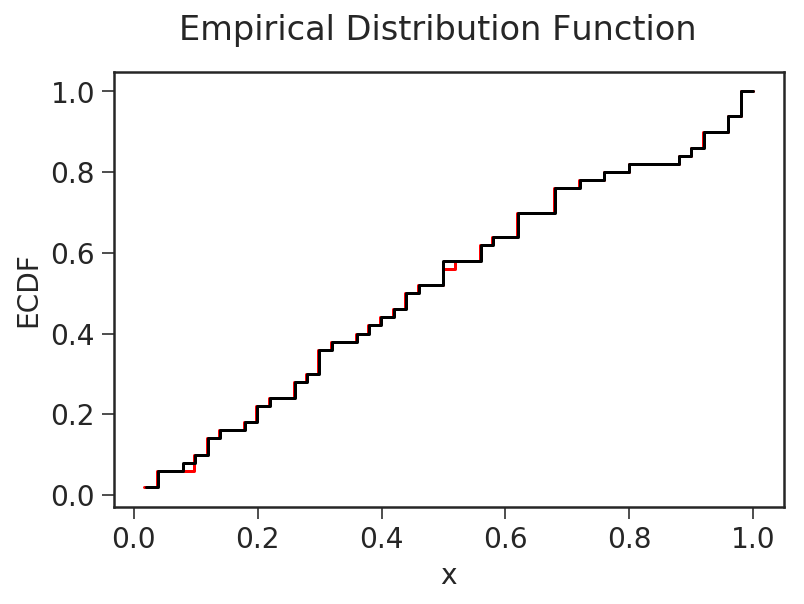

In [118]:

# Empirical distribution function
# Wont work in atom but should in jupyter
# make into a function for ranked KS (x=np.linspace(1,len(sample))) and KS (see below)
#def plotECDF(sample1,sample2,x)

sample = np.random.uniform(0, 1, 50)
sample2 = np.random.uniform(0, 50, 900)
def plotECDF(sample1,sample2,xlab="x",ylab="ECDF",title="Empirical Distribution Function",color1="red",color2="black"):
    ecdf = sm.distributions.ECDF(sample)
    ecdf2 = sm.distributions.ECDF(sample2)
    x1 = np.linspace(min(sample), max(sample))
    y = ecdf(x1)
    x2 = np.linspace(min(sample2), max(sample))
    y2 = ecdf(x2)
    plt.step(x1, y,color=color1)
    plt.step(x2,y2,color=color2)
    plt.ylabel(ylab); plt.xlabel(xlab)
    plt.suptitle(title)
    plt.show()
plotECDF(sample,sample2)

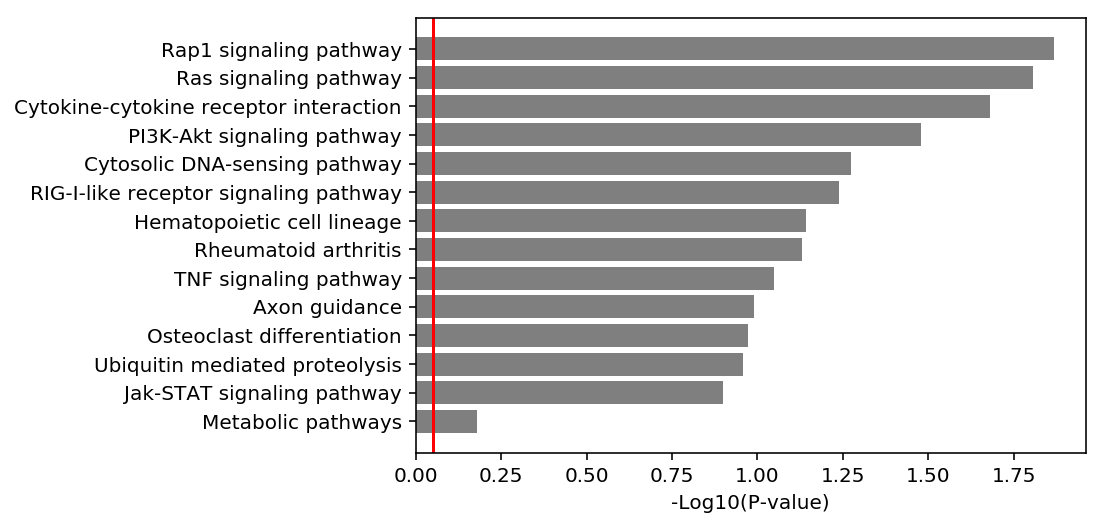

In [10]:
gl = ['SCARA3', 'LOC100044683', 'CMBL', 'CLIC6', 'IL13RA1', 'TACSTD2', 'DKKL1', 'CSF1',
     'SYNPO2L', 'TINAGL1', 'PTX3', 'BGN', 'HERC1', 'EFNA1', 'CIB2', 'PMP22', 'TMEM173']
pathways = KEGGanalysis(gl,gene_sets="KEGG_2016")
PlotKEGG(pathways)

In [65]:
pathways

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes,-log10(pvalue)
0,Rap1 signaling pathway_Homo sapiens_hsa04015,2/211,0.013575,0.097370,0.012695,0.091258,-1.961363,8.432992,EFNA1;CSF1,1.867274
1,Ras signaling pathway_Homo sapiens_hsa04014,2/227,0.015592,0.097370,0.014588,0.091258,-1.982710,8.250048,EFNA1;CSF1,1.807097
2,Cytokine-cytokine receptor interaction_Homo sa...,2/265,0.020865,0.097370,0.019555,0.091258,-1.829001,7.077657,CSF1;IL13RA1,1.680582
3,PI3K-Akt signaling pathway_Homo sapiens_hsa04151,2/341,0.033299,0.116546,0.031363,0.109770,-1.989259,6.767930,EFNA1;CSF1,1.477573
4,Cytosolic DNA-sensing pathway_Homo sapiens_hsa...,1/64,0.053050,0.128711,0.054334,0.131134,-1.590534,4.670632,TMEM173,1.275314
5,RIG-I-like receptor signaling pathway_Homo sap...,1/70,0.057885,0.128711,0.059223,0.131134,-1.563846,4.455855,TMEM173,1.237432
6,Hematopoietic cell lineage_Homo sapiens_hsa04640,1/88,0.072252,0.128711,0.073764,0.131134,-1.611502,4.234375,CSF1,1.141150
7,Rheumatoid arthritis_Homo sapiens_hsa05323,1/90,0.073835,0.128711,0.075368,0.131134,-1.574283,4.102448,CSF1,1.131735
8,TNF signaling pathway_Homo sapiens_hsa04668,1/110,0.089531,0.128711,0.091281,0.131134,-1.699253,4.100583,CSF1,1.048025
9,Osteoclast differentiation_Homo sapiens_hsa04380,1/132,0.106507,0.128711,0.108521,0.131134,-1.605330,3.595203,CSF1,0.972621
